<a href="https://colab.research.google.com/github/Awerdos/Anomaly-Detection-with-AutoEncoder/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [108]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64

dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)
data = dataset.data

mask_normal = np.where(dataset.targets == 4)[0]
mask_anomaly = np.where(dataset.targets != 4)[0]

Numebrs = []
for i in range(10):
  if i == 4:
    continue
  mask_numbers = np.where(dataset.targets == i)[0]
  Numebrs.append(torch.utils.data.Subset(dataset, mask_numbers))

Normal = torch.utils.data.Subset(dataset, mask_normal)
Anomaly = torch.utils.data.Subset(dataset, mask_anomaly)

# Data for AutoEncoders

trainloader_ae = torch.utils.data.DataLoader(Normal, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_ae = torch.utils.data.DataLoader(Anomaly, batch_size=64, shuffle=True, num_workers=2)

# Data for Classifier
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)

dataset.targets = torch.where(dataset.targets == 4, 1 , 0)
len_trainset = int(0.7*len(dataset))
len_testset = int(0.3*len(dataset))

trainset_classifier, testset_classfier = torch.utils.data.random_split(dataset, [len_trainset, len_testset])

trainloader_class = torch.utils.data.DataLoader(trainset_classifier, batch_size=64, shuffle=True, num_workers=2)
testloader_class = torch.utils.data.DataLoader(testset_classfier, batch_size=1, shuffle=True, num_workers=2)

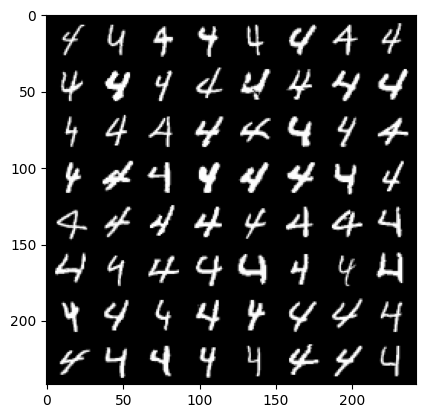

In [109]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))


dataiter = iter(trainloader_ae)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
plt.show()

In [110]:
class AutoEncoder_convolutional(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 7)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self,x):
    compressed = self.encoder(x)
    decompressed = self.decoder(compressed)
    return decompressed

In [111]:
class AutoEncoder_linear(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64)
    )

    self.decoder = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid(),
        nn.Unflatten(1, (1, 28, 28))
    )

  def forward(self,x):
    compressed = self.encoder(x)
    decompressed = self.decoder(compressed)
    return decompressed

In [112]:
class Classifier_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 14 * 14, 2)
        )

  def forward(self, x):
        return self.network(x)

In [113]:
def E(x_pred,x):
  return torch.mean((x - x_pred) ** 2)

In [114]:
def train_AutoEncoder(model, num_epoch):
  print(f"Model: {model.__class__.__name__}")
  start_time = time.time()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epoch):
    running_loss = 0.0

    for i,data in enumerate(trainloader_ae):
      input, target = data

      optimizer.zero_grad()

      forward = model(input)
      loss = E(forward, input)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f'[{epoch + 1}/{num_epoch}] loss: {running_loss / len(trainloader_ae):.3f}')

  print(f'Finished Training in {time.time() - start_time:.2f}')

In [115]:
def train_Classifier(model, num_epoch):
  print(f"Model: {model.__class__.__name__}")
  start_time = time.time()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epoch):
    running_loss = 0.0

    for i,data in enumerate(trainloader_class):
      input, target = data

      # targets = target.float().view(-1, 1)
      optimizer.zero_grad()

      forward = model(input)
      loss = criterion(forward, target)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f'[{epoch + 1}/{num_epoch}] loss: {running_loss / len(trainloader_class):.3f}')

  print(f'Finished Training in {time.time() - start_time:.2f}')

In [116]:
conv_model = AutoEncoder_convolutional()
linear_model = AutoEncoder_linear()
CNN_model = Classifier_CNN()
models = [CNN_model,linear_model,conv_model]

num_epochs = 5

for model in models[:1]:
  train_Classifier(model,num_epochs)
for model in models[1:]:
  train_AutoEncoder(model,num_epochs)


Model: Classifier_CNN
[1/5] loss: 0.074
[2/5] loss: 0.026
[3/5] loss: 0.020
[4/5] loss: 0.016
[5/5] loss: 0.015
Finished Training in 74.39
Model: AutoEncoder_linear
[1/5] loss: 0.076
[2/5] loss: 0.050
[3/5] loss: 0.037
[4/5] loss: 0.030
[5/5] loss: 0.025
Finished Training in 8.80
Model: AutoEncoder_convolutional
[1/5] loss: 0.076
[2/5] loss: 0.053
[3/5] loss: 0.046
[4/5] loss: 0.022
[5/5] loss: 0.014
Finished Training in 17.40


In [117]:
trainloader_single = torch.utils.data.DataLoader(Normal, batch_size=1, shuffle=False)
list_loss_array_normal = []

for model in models[1:]:
  with torch.no_grad():
    loss_array_normal = []
    for i ,data in enumerate(trainloader_single):
        images, target = data
        forward = model(images)
        loss = E(forward, images)
        loss_array_normal.append(loss.item())
  list_loss_array_normal.append(loss_array_normal)

In [118]:
list_T = []

for loss_array_normal in list_loss_array_normal:
  std = np.std(np.array(loss_array_normal))
  mean = np.mean(np.array(loss_array_normal))
  k = 2

  T = mean + std*k
  print(f"Model:{model.__class__.__name__}")
  print(f"T: {T}")
  list_T.append(T)
  print(f"Średni błąd: {np.mean(loss_array_normal)}\n")

Model:AutoEncoder_convolutional
T: 0.0423076441735421
Średni błąd: 0.022462404349076575

Model:AutoEncoder_convolutional
T: 0.02161725814594055
Średni błąd: 0.011553505178125182



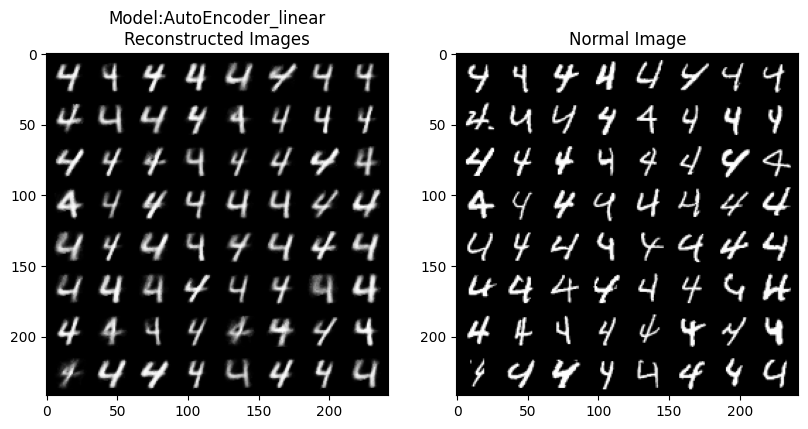

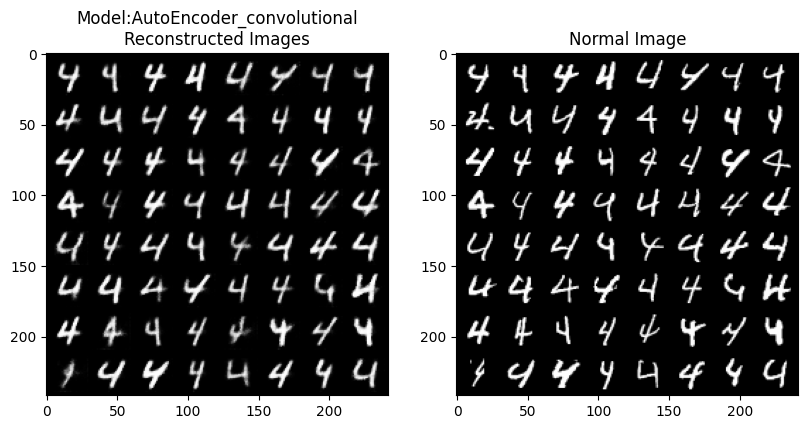

In [119]:
dataiter = iter(trainloader_ae)
images, labels = next(dataiter)

for model in models[1:]:
  with torch.no_grad():
      forward = model(images)
      loss = E(forward, images)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.title(f"Model:{model.__class__.__name__}\nReconstructed Images")
  imshow(torchvision.utils.make_grid(forward))
  plt.subplot(1, 3, 2)
  plt.title(f"Normal Image")
  imshow(torchvision.utils.make_grid(images))
  plt.show()

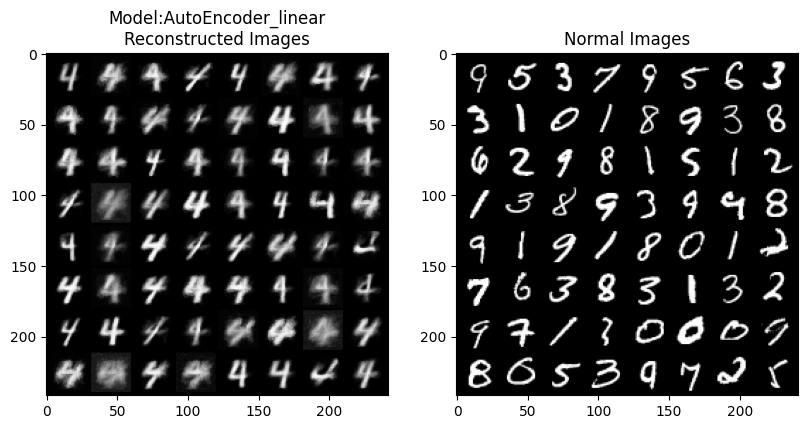

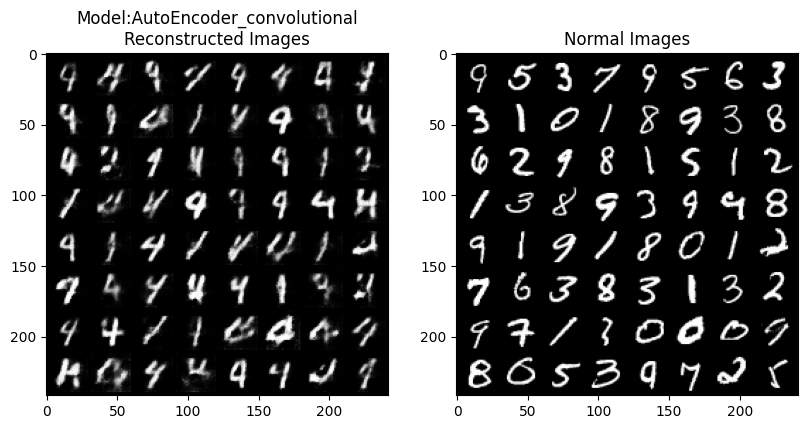

In [120]:
dataiter = iter(testloader_ae)
images, labels = next(dataiter)
Status = None
for model in models[1:]:
  with torch.no_grad():
      forward = model(images)
      loss = E(forward, images)
      if loss > T:
        Status = "Anomaly"
      else:
        Status = "Normal"

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  # plt.title(f"Model:{model.__class__.__name__}\n Status:{Status}\n Loss:{loss:2f}")
  plt.title(f"Model:{model.__class__.__name__}\nReconstructed Images")
  imshow(torchvision.utils.make_grid(forward))
  plt.subplot(1, 3, 2)
  plt.title(f"Normal Images")
  imshow(torchvision.utils.make_grid(images))
  plt.show()

In [121]:
testloader_single = torch.utils.data.DataLoader(Anomaly, batch_size=1, shuffle=False)
list_loss_array_anomaly = []
for model in models[1:]:
  with torch.no_grad():
    loss_array_anomaly = []
    for i ,data in enumerate(testloader_single):
        images, _ = data
        forward = model(images)
        loss = E(forward, images)
        loss_array_anomaly.append(loss.item())
  list_loss_array_anomaly.append(loss_array_anomaly)

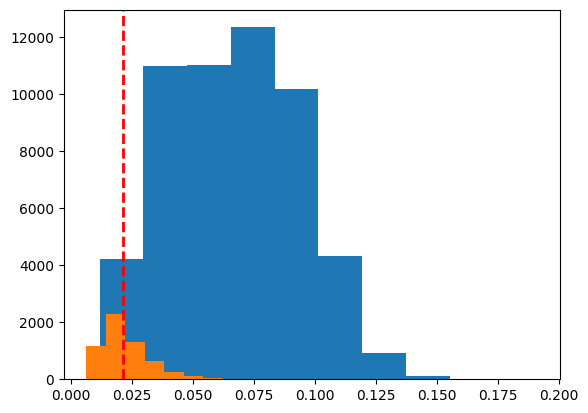

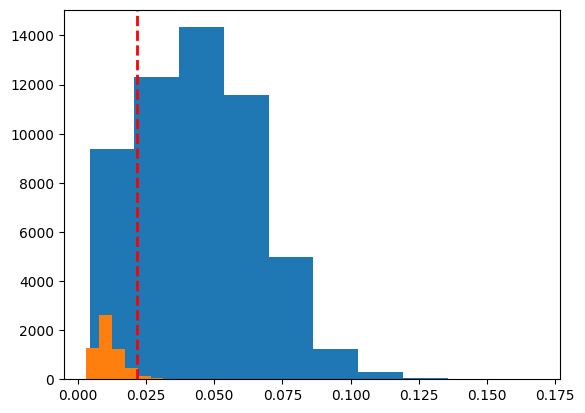

In [124]:
for loss_array_anomaly,loss_array_normal in zip(list_loss_array_anomaly,list_loss_array_normal):

  plt.hist(loss_array_anomaly)
  plt.hist(loss_array_normal)
  plt.axvline(x=T, color='r', linestyle='dashed', linewidth=2)
  plt.show()

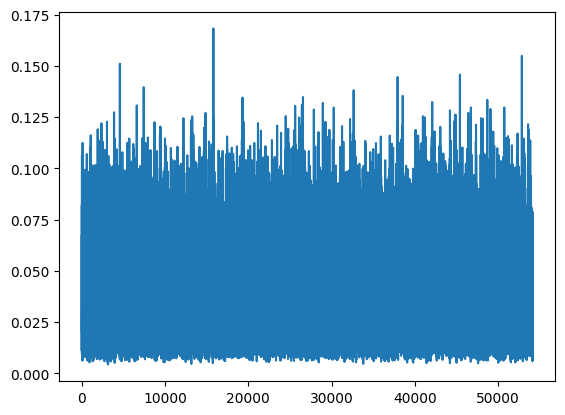

In [125]:
plt.plot(loss_array_anomaly)
plt.show()